# =================== Assignment 4 ======================

## Amazon Fine Food Reviews Analysis and Naive Baiye's Classification

​
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>
​
Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 
​
Attribute Information:
​
1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review
​

#### Objective:
1] Implement Naive Baye's

2] Best Alpha using CV

3] Feature Importance

4] Confusion Matrix

5] Precision, Recall, F1-Score

Classify the Score based on Review and Calculate TPR, FPR, TNR, FNR based on Confusion Matrix

In [4]:
# ============================== loading libraries ===========================================
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import string
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import re

import sqlite3


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
# =============================================================================================

In [3]:
con = sqlite3.connect('database.sqlite') 
amzn = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print("Shape of Amzn Dataframe :",amzn.shape)
print("\n")
print("Head(2) of Amzn Dataframe")
print("**************************")
amzn.head(2)

Shape of Amzn Dataframe : (525814, 10)


Head(2) of Amzn Dataframe
**************************


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


**Function to impute the review to -1- "Positive" (Rating of 4 or 5) or -0- "Negative" (rating of 1 or 2).**

In [5]:
def part(data):
    if data > 3:
        return 1
    else:
        return 0

**Applying Function to Amazon['Score'] factor**

In [6]:
amzn['Score'] = amzn['Score'].map(part)

In [7]:
amzn.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


**Taking 1000-1000 of Positive and Negative observation out of 500k as Machine is Slow for further analysis**

In [8]:
#Positive = amzn[amzn['Score'] == 1].head(1000)
#Negative = amzn[amzn['Score'] == 0].head(1000)
#combined = [Positive,Negative]
#amazon = pd.concat(combined)
#amazon = sklearn.utils.shuffle(amazon)
print("Shape of Amazon Dataframe :",amzn.shape)

Shape of Amazon Dataframe : (525814, 10)


# Data Preprocessing

**Checking how many observations have Duplicated values in dataset with Variables['UserId','ProfileName','Score','Time']**

In [9]:
print(amzn.duplicated(subset=['UserId','ProfileName','Score','Time']).sum())

192811


**Dropping Duplicated values and keeping only first occuring observation in dataset**

In [10]:
amzn = amzn.drop_duplicates(subset=['UserId','ProfileName','Score','Time'], keep='first')

In [11]:
print(amzn.duplicated().sum())

0


**Cross checking for missing data in Dataset**

In [12]:
amzn.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

**The value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible, So Going to keep all the observations which have HelpfulnessNumerator is less than or Equal to HelpfulnessDenominator.**

In [13]:
amzn = amzn[amzn['HelpfulnessNumerator'] <= amzn['HelpfulnessDenominator']]

(333001, 10)
1    277625
0     55376
Name: Score, dtype: int64


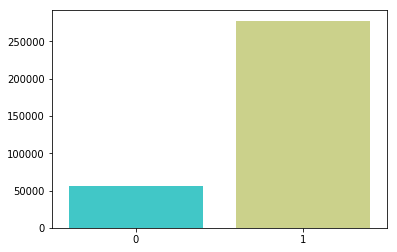

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(amzn.shape)

#How many positive and negative reviews are present in our dataset?
class_bal = amzn['Score'].value_counts()
print(class_bal)

#Plotting barplot for target variable to compare balance between them.
sns.barplot(class_bal.index, class_bal.values, palette="rainbow")

**Function which will**

1] Remove all html sets of sentences from reviews

2] Remove all punctuation present in reviews as are not necessary for analysis and modeling

In [15]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

**Code Working**

1] Remove HTMl tags

2] Split the reviews

3] Converting reviews to lower case

4] Removing Stop words

5] Storing of all words used to describe positive reviews and negative reviews.

In [16]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''


for sent in amzn['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower()))
                    filtered_sentence.append(s)
                    if (amzn['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(amzn['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

**Adding a column of CleanedText which displays the data after pre-processing of the review**

In [17]:
amzn['CleanedText'] = final_string
amzn = amzn.sort_values('Time')
print(amzn.head(2))

            Id   ProductId         UserId         ProfileName  \
138706  150524  0006641040  ACITT7DI6IDDL     shari zychinski   
138683  150501  0006641040  AJ46FKXOVC7NR  Nicholas A Mesiano   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
138706                     0                       0      1  939340800   
138683                     2                       2      1  940809600   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138683  I can remember seeing the show when it aired o...   

                                              CleanedText  
138706  witti littl book make son laugh loud recit car...  
138683  rememb see show air televis year ago child sis...  


**Taking Sample of 5000 Observation after preprocess of data and after sorting all the data.**

##### Taking Sample of 5000 because Machine is Not responding if taking large sample of dataset or getting "Memory Error".

In [18]:
amazon = amzn.head(100000)
print(amazon.shape)

(100000, 11)


In [19]:

from sklearn.metrics import accuracy_score
amazon.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...


# DONT TOUCH UP FROM HERE

**Spliting data to train and test as 80-20 for further steps and analysis**

In [20]:
X_train = amazon['CleanedText'].head(80000)
X_test = amazon['CleanedText'].tail(20000)
y_train = amazon['Score'].head(80000)
y_test = amazon['Score'].tail(20000)

print("Text:  ",len(X_train), len(X_test), len(X_train) + len(X_test))
print("Score: ",len(y_train), len(y_test), len(y_train) + len(y_test))

Text:   80000 20000 100000
Score:  80000 20000 100000


In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Functions to call again and again whenever needed

**Function takes Train and test data to find better Alpha value and GridCv Function to perform Cross Validation to find Better Alpha (Laplace Smoothing)** 

In [22]:
def best_Alpha_train_test(X_train, y_train, X_test, y_test):
    alpha = [0,0.01,0.1,1,10,100,1000]
    for i in alpha:
        # instantiate learning model (Alpha = 6 Values)
        NB = MultinomialNB(alpha=i)

        # fitting the model on crossvalidation train
        NB.fit(X_train, y_train)
        
        # predict the response on the crossvalidation train
        pred = NB.predict(X_test)

        # evaluate Accuracy
        acc = accuracy_score(y_test, pred, normalize=True) * float(100)
        print("=========================================")
        print('Accuracy for Alpha = ',i,' is ',acc,' %')
        print("=========================================")
        

        
def Grid_CV(X_train, y_train): 
    params = [{'alpha':[0,0.01,0.1,1,10,100,1000]}]
    tuned_classifier = MultinomialNB()
    grid_search = GridSearchCV(estimator=tuned_classifier, param_grid=params, scoring = 'f1', cv = 3)
    grid_search = grid_search.fit(X_train, y_train)
    print("Grid Search CV Best 'Alpha': ")        
    print("=================================")
    print(grid_search.best_params_)

**Function to plot ALpha and Error based on Cross Validation**

In [23]:
def crossval_error_plot(X_train, y_train):
    
    # creating odd list of K for KNN
    alpha = [0,0.01,0.1,1,10,100,1000]

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in alpha:
        NB = MultinomialNB(alpha=k)
        scores = cross_val_score(NB, X_train, y_train, cv=3, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = alpha[MSE.index(min(MSE))]
    print('\nThe Optimal Alpha is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.figure(figsize=(10,8))
    plt.plot(alpha, MSE)

    for xy in zip(alpha, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("The misclassification error for each Alpha value is : ", np.round(MSE,3))
    print("CV Scores: ",cv_scores)

**Function to print Confusion Matrix, CV Score, Classification Report, Plot Confusion Matrix and Get Accuracy of Model on Test Data with Defined Classifier with Better Alpha**

In [24]:
def fit_predict_performance_CM_CV(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    
    cv_perfor = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=3)
    k_fold_performance = cv_perfor.mean()
    
    print("K-fold cross validation score of model for k = 3 is :")
    print(k_fold_performance * float(100))
    print("====================================")
    print("====================================")
    print()
    
    print("Correct Classified Data Point: ",accuracy_score(y_test, prediction, normalize=False))
    print()
    print("Correct % Classified Data Point: ",accuracy_score(y_test, prediction) * 100 ,"%")
    print("====================================")
    print()
    
    print("====== Confusion matrix ======= ")
    cm = confusion_matrix(y_test,prediction)
    print(cm)
    

    df_CM = pd.DataFrame(cm)
    print("Confusion Matrix")
    print("==================")
    print(df_CM)
    print("==================")
    fig = plt.figure()
    sns.heatmap(df_CM, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    print()
    print("====== Classification Report ======= ")
    cr = classification_report(y_test,prediction)
    print(cr)

### Function for Word Cloud to Visualize Important Features in Positive and Negative Review or Most occuring Words in Reviews

In [61]:
### Function for Word Cloud to Visualize Important Features in Positive and Negative Review or Most occuring Words in Reviews

def wordimpcloud(data):
    # nltk.FreqDist generates a tally of the number of times each word appears
    # and stores the results in a special dictionary.
    fdist = nltk.FreqDist(data)

    # This is the dictionary we'll use for the word cloud.
    # Loaded with the FOR loop below.
    word_dict = {}

    for key in fdist:
        word_dict[key] = fdist[key]

    wordCloud = WordCloud(max_words= 500, height= 1500, width= 3000)

    print("\nWord cloud with most frequently occurring Words (unigrams).")

    wordCloud.generate_from_frequencies(word_dict)
    plt.figure(figsize=(15,30))
    plt.title('Most frequently occurring words (unigrams)')
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [25]:
y_train = y_train.values
y_test = y_test.values

# Bag Of Words(BoW), KNN

**Creating Bag of words using CountVectorizer() function and printing Shape of same and Unique words present in reviews**

In [26]:
#BoW
CV = CountVectorizer() #in scikit-learn
Bow_X_train = CV.fit_transform(X_train)
Bow_X_test = CV.transform(X_test)
print("Shape of BOW vectorizer: ",Bow_X_train.get_shape(), Bow_X_test.get_shape())
print("Number of unique words in 'Bow_X_train': ", Bow_X_train.get_shape()[1])
print("Number of unique words in 'Bow_X_test': ", Bow_X_test.get_shape()[1])

Shape of BOW vectorizer:  (80000, 33721) (20000, 33721)
Number of unique words in 'Bow_X_train':  33721
Number of unique words in 'Bow_X_test':  33721


**Calling classifier function with "Bow_X_train, y_train, Bow_X_test, y_test" for better ALpha with Highest accuracy for BOW**

In [27]:
warnings.filterwarnings('ignore')

In [28]:
best_Alpha_train_test(Bow_X_train, y_train, Bow_X_test, y_test)

Accuracy for Alpha =  0  is  88.315  %
Accuracy for Alpha =  0.01  is  89.095  %
Accuracy for Alpha =  0.1  is  89.525  %
Accuracy for Alpha =  1  is  90.02  %
Accuracy for Alpha =  10  is  85.99  %
Accuracy for Alpha =  100  is  85.275  %
Accuracy for Alpha =  1000  is  85.28  %


In [29]:
Grid_CV(Bow_X_train, y_train)

Grid Search CV Best 'Alpha': 
{'alpha': 1}


K-fold cross validation score of model for k = 3 is :
90.44250274704763

Correct Classified Data Point:  18004

Correct % Classified Data Point:  90.02 %

====== Confusion matrix ======= 
[[ 1754  1190]
 [  806 16250]]
Confusion Matrix
      0      1
0  1754   1190
1   806  16250

====== Classification Report ======= 
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      2944
           1       0.93      0.95      0.94     17056

   micro avg       0.90      0.90      0.90     20000
   macro avg       0.81      0.77      0.79     20000
weighted avg       0.90      0.90      0.90     20000



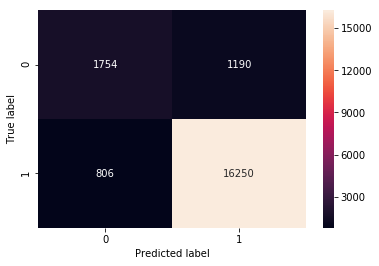

In [31]:
classifier = MultinomialNB(alpha= 1)
fit_predict_performance_CM_CV(classifier, Bow_X_train, y_train, Bow_X_test, y_test)

**==================================================================================================================================**

**Observation on BoW Naive Bayes:**

1] After Implementing different approach to find better alpha Or Laplace Smoothing for the Bow Model,

    Such as: 
    - Different ALpha Model
    - GridSearchCV
    - Error Plot
    
        Alpha = 1 came out to be Best laplace smoothing for the Modeling.

2] Accuracy of Model On test is 90.02 % Where CV Accuracy is 90.44 %, So surely our Naive Baiyes is working Better than KNN.

3] There is 18004 Points is correctly classified out of 20000 Test Points with Accuracy approximate 90 % with Lapalce Smoothing(Alpha) = 1

4] As Data is Imbalance and most of the data points belong to Positive data points, We can Observe,
    
    Weighted:
    F1-Score = 90 %
    Precision = 90 %
    Recall = 90 %
    
    Whereas,
    Macro avg:
    F1-Score = 79 %
    Precision = 81 %
    Recall = 77 %

**==================================================================================================================================**

# Most Frequent Feature Words in Postive and Negative Reviews

In [32]:
freq_positive_dist=nltk.FreqDist(all_positive_words)
freq_negative_dist=nltk.FreqDist(all_negative_words)
print("Most Common and Top Feature Words in Positive Review")
print("====================================================")
print(freq_positive_dist.most_common(50))
print()
print("Most Common and Top Feature Words in Negative Review")
print("====================================================")
print(freq_negative_dist.most_common(50))

Most Common and Top Feature Words in Positive Review
[('like', 124538), ('tast', 115988), ('good', 100085), ('flavor', 96603), ('love', 96593), ('use', 93419), ('great', 92881), ('one', 87018), ('product', 82702), ('tri', 79105), ('tea', 74536), ('coffe', 72974), ('make', 67057), ('get', 65275), ('food', 58135), ('would', 50525), ('time', 50143), ('buy', 49144), ('realli', 47133), ('eat', 46242), ('amazon', 45696), ('price', 44206), ('find', 44161), ('best', 43617), ('much', 43079), ('order', 42989), ('also', 42655), ('dont', 41800), ('littl', 41225), ('drink', 38953), ('well', 38691), ('store', 38196), ('dog', 37783), ('ive', 37276), ('bag', 36833), ('even', 34969), ('day', 32899), ('better', 32811), ('mix', 32739), ('chocol', 32254), ('year', 31394), ('recommend', 31119), ('water', 29556), ('sweet', 29509), ('sugar', 29070), ('box', 29032), ('found', 28435), ('cup', 28012), ('first', 27732), ('give', 26991)]

Most Common and Top Feature Words in Negative Review
[('tast', 33462), ('li

## Important Word Features In Positive Reviews


Word cloud with most frequently occurring Words (unigrams).


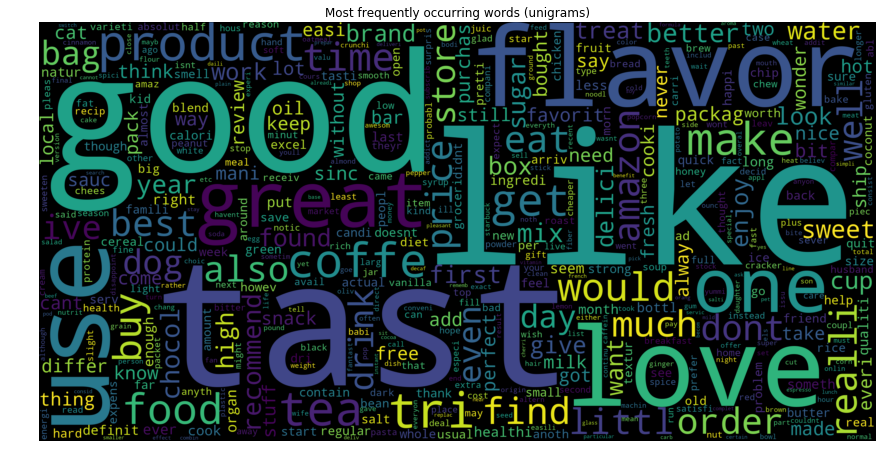

In [62]:
wordimpcloud(all_positive_words)

## Important Word Features In Negative Reviews


Word cloud with most frequently occurring Words (unigrams).


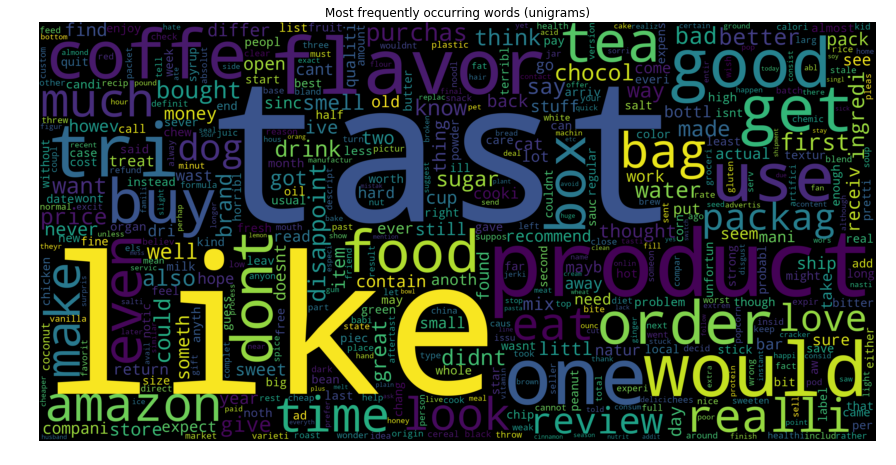

In [63]:
wordimpcloud(all_negative_words)

# Tf-idf KNN

**Tfidf and finding Shape of data and Unique words in Dataframe**

In [65]:
tf_idf = TfidfVectorizer()
Tfidf_X_train = tf_idf.fit_transform(X_train)
Tfidf_X_test = tf_idf.transform(X_test)
print("Shape of BOW vectorizer: ",Tfidf_X_train.get_shape(), Tfidf_X_test.get_shape())
print("Number of unique words in 'Tfidf_X_train': ", Tfidf_X_train.get_shape()[1])
print("Number of unique words in 'Tfidf_X_test': ", Tfidf_X_test.get_shape()[1])

Shape of BOW vectorizer:  (80000, 33721) (20000, 33721)
Number of unique words in 'Tfidf_X_train':  33721
Number of unique words in 'Tfidf_X_test':  33721


# Top 10 Features in Tfidf

In [66]:
# source: https://buhrmann.github.io/tfidf-analysis.html
features = tf_idf.get_feature_names()
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(Tfidf_X_train[1,:].toarray()[0],features,10)
top_tfidf

,feature,tfidf
0,book,0.365523
1,televis,0.269617
2,song,0.259891
3,preschool,0.258105
4,thirti,0.239940
5,teach,0.239476
6,seri,0.237260
7,student,0.216004
8,sister,0.189603
9,air,0.184065


**Calling classifier function with "Tfidf_X_train, y_train, Tfidf_X_test, y_test" for better K with Highest accuracy for Tfidf data**

In [67]:
best_Alpha_train_test(Tfidf_X_train, y_train, Tfidf_X_test, y_test)

Accuracy for Alpha =  0  is  86.79  %
Accuracy for Alpha =  0.01  is  87.42  %
Accuracy for Alpha =  0.1  is  87.29  %
Accuracy for Alpha =  1  is  85.47  %
Accuracy for Alpha =  10  is  85.28  %
Accuracy for Alpha =  100  is  85.28  %
Accuracy for Alpha =  1000  is  85.28  %


In [68]:
Grid_CV(Tfidf_X_train, y_train)

Grid Search CV Best 'Alpha': 
{'alpha': 0.01}



The Optimal Alpha is 0.


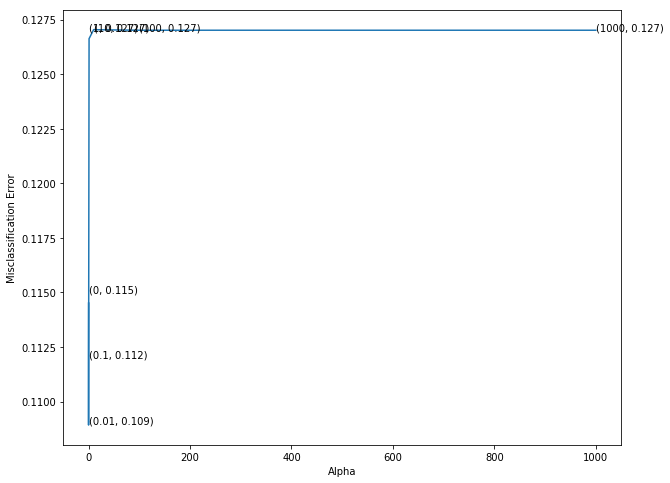

The misclassification error for each Alpha value is :  [0.115 0.109 0.112 0.127 0.127 0.127 0.127]
CV Scores:  [0.8854874941828922, 0.8910750124661169, 0.8883375241841578, 0.8733750021479566, 0.8729624998040485, 0.8729874999603081, 0.8729874999603081]


In [69]:
crossval_error_plot(Tfidf_X_train, y_train)

K-fold cross validation score of model for k = 3 is :
89.10750124661169

Correct Classified Data Point:  17484

Correct % Classified Data Point:  87.42 %

====== Confusion matrix ======= 
[[  549  2395]
 [  121 16935]]
Confusion Matrix
     0      1
0  549   2395
1  121  16935

====== Classification Report ======= 
              precision    recall  f1-score   support

           0       0.82      0.19      0.30      2944
           1       0.88      0.99      0.93     17056

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.85      0.59      0.62     20000
weighted avg       0.87      0.87      0.84     20000



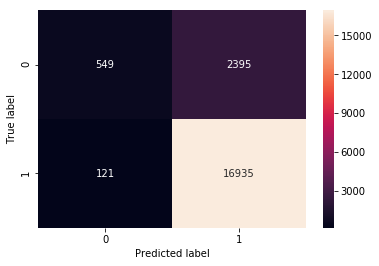

In [70]:
classifier = MultinomialNB(alpha= 0.01)
fit_predict_performance_CM_CV(classifier, Tfidf_X_train, y_train, Tfidf_X_test, y_test)

**==================================================================================================================================**

**Observation on Tfidf Naive Bayes:**

1] After Implementing different approach to find better alpha Or Laplace Smoothing for the Tfidf Model,

    Such as: 
    - Different ALpha Model
    - GridSearchCV
    - Error Plot
    
        Alpha = 0.01 came out to be Best laplace smoothing for the Modeling.

2] Accuracy of Model On test is 87.42 % Where CV Accuracy is 89.10 % that is lower than Bow Model with ALpha = 1 with F1 Score 62 %

3] There is 17484 Points is correctly classified out of 20000 Test Points with Accuracy approximate 87.4 % with Lapalce Smoothing(Alpha) = 0.01

4] As Data is Imbalance and most of the data points belong to Positive data points, We can Observe score are same as Bow Naive Bayes Model and It seems 0.01 is Best ALpha for this Dataset.
    
    Weighted:
    F1-Score = 84 %
    Precision = 87 %
    Recall = 87 %
    
    Whereas,
    Macro avg:
    F1-Score = 62 %
    Precision = 85 %
    Recall = 59 %

**==================================================================================================================================**